# ANN
## Architecture
Consists of 3 layers:
- Input layer: $N_I = 2$ neurons
- Hidden layer: $N_H = 2$ neurons
- Output layer: $N_O = 1$ neuron
## Activation functions
- Hidden layer: sigmoid (given in the problem)
- Output layer: sigmoid (since we want a binary output, it's better to get the model output in the range $[0, 1]$)
## Loss function
Mean squared error loss
$$
L = \frac{1}{s} \sum_{i=1}^{s} \sum_{k=1}^{N_O} (\hat{y_k}^{(i)} - y_k^{(i)})^2
$$
where $s$ represents the batch size. Note that $s = n_{train}$ in case of Deterministic Gradient Descent.
## Forward propagation
Let the weights of hidden layer be $\alpha \in R^{N_H \times N_I}$ and weights of output layer be $\beta \in R^{N_O \times N_H}$.
Equations for forward propagation for $i^{th}$ sample $x^{(i)} \in R^{N_I}$ are:
$$
z^{(i)} = \sigma(\alpha x^{(i)} + b_H) \quad \text{for hidden layer}\\
\hat{y}^{(i)} = \sigma(\beta z^{(i)} + b_O) \quad \text{for output layer}
$$
where $b_H \in R^{N_H}$ and $b_O \in R^{N_O}$ are the biases for hidden and output layers respectively.<br>
**Note:** To simplify the notation, I'll add a value $1$ to the input vector $x^{(i)}$ and take the bias term in the matrix $\alpha$ itself. So, $\alpha \in R^{(N_H) \times (N_I+1)}$.<br>
Similarly, I'll add a value $1$ to the hidden layer output $z^{(i)}$ and take the bias term in the matrix $\beta$ itself. So, $\beta \in R^{(N_O) \times (N_H+1)}$.
## Backward propagation
### Output layer
$$
\frac{\partial L}{\partial \beta_{km}} = \frac{1}{s} \sum_{i=1}^{s} 2(\hat{y_k}^{(i)} - y_k^{(i)}) \sigma'(\sum_{m=0}^{N_H}z_m^{(i)}\beta_{km})z_m^{(i)}
$$
where $\beta_{km}$ represents the weight corresponding to $m^{th}$ neuron in hidden layer and $k^{th}$ neuron in output layer ($m = 0$ is a special case for bias term).<br>
Since we are using sigmoid activation function, $\sigma'(x) = \sigma(x)(1 - \sigma(x))$. Therefore:
$$
\frac{\partial L}{\partial \beta_{km}} = \frac{1}{s} \sum_{i=1}^{s} 2(\hat{y_k}^{(i)} - y_k^{(i)}) \hat{y_k}^{(i)}(1 - \hat{y_k}^{(i)})z_m^{(i)}
$$
### Hidden layer
$$
\frac{\partial L}{\partial \alpha_{mp}} = \frac{1}{s} \sum_{i=1}^{s} \sum_{k=1}^{N_O} 2(\hat{y_k}^{(i)} - y_k^{(i)}) \sigma'(\sum_{m=0}^{N_H}z_m^{(i)}\beta_{km})\beta_{km}\sigma'(\sum_{p=0}^{N_I}x_p^{(i)}\alpha_{mp})x_p^{(i)}
$$
Using the same logic as above, we get:
$$
\frac{\partial L}{\partial \alpha_{mp}} = \frac{1}{s} \sum_{i=1}^{s} \sum_{k=1}^{N_O} 2(\hat{y_k}^{(i)} - y_k^{(i)}) \hat{y_k}^{(i)}(1 - \hat{y_k}^{(i)})\beta_{km}z_m^{(i)}(1 - z_m^{(i)})x_p^{(i)}
$$
Note that the above equation isn't valid for $m = 0$ since there is no weight corresponding to bias term in the input layer.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Create ANN class

In [2]:
class ANN:
    """
    A simple artificial neural network with one hidden layer.
    """
    def __init__(self,
                 input_dim: int,
                 hidden_dim: int,
                 output_dim: int):
        """
        Args:
            input_dim (int): The number of input features
            hidden_dim (int): The number of hidden units
            output_dim (int): The number of output units
        """
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.alpha = np.random.randn(hidden_dim, input_dim + 1)
        self.beta = np.random.randn(output_dim, hidden_dim + 1)

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def _loss_fn(self, y, y_hat):
        return np.mean((np.array(y) - np.array(y_hat)) ** 2)

    @staticmethod
    def accuracy_score(y, y_hat):
        return np.mean(np.array(y) == np.array(y_hat)) * 100
    
    def predict(self, X: np.ndarray, threshold: float = 0.5):
        """
        Args:
            X (ndarray): Input data with shape (num_samples, input_dim)
            threshold (float): Threshold for the binary classification
        """
        num_samples = X.shape[0]
        y_hat = np.zeros(num_samples)
        for i in range(num_samples):
            x = X[i].reshape(-1, 1)
            y_hat[i] = self.forward(x)[0][0]

        return (y_hat > threshold).astype(int)
    
    def forward(self, x: np.ndarray):
        """
        Args:
            x (ndarray): Input data with shape (input_dim, 1)
        """
        # Add 1 to the input for the bias term
        x_1 = np.concatenate([np.ones((1, 1)), x], axis=0) # (input_dim + 1, 1)

        z = self._sigmoid(self.alpha @ x_1) # (hidden_dim, 1)

        # Add 1 to the hidden layer output for the bias term
        z_1 = np.concatenate([np.ones((1, 1)), z], axis=0) # (hidden_dim + 1, 1)

        y_hat = self._sigmoid(self.beta @ z_1) # (output_dim, 1)

        return y_hat, z_1, x_1
    
    def backward(self, X: list[np.ndarray],
                 Z: list[np.ndarray],
                 Y_hat: list[np.ndarray],
                 Y: list[float]):
        """
        Args:
            X (list): List of input data each with shape (input_dim + 1, 1)
            Z (list): List of hidden layer output each with shape (hidden_dim + 1, 1)
            Y_hat (list): List of predicted values each with shape (output_dim, 1)
            Y (list): List of target values
        """
        s = len(X)
        # Gradient matrices
        grad_alpha = np.zeros_like(self.alpha)
        grad_beta = np.zeros_like(self.beta)

        # Calculate the gradients of beta
        for k in range(self.output_dim):
            for m in range(self.hidden_dim + 1):
                grad_val = 0.0
                for i in range(s):
                    yh = Y_hat[i][k]
                    grad_val += 2 * (yh - Y[i]) * yh * (1 - yh) * Z[i][m]
                grad_beta[k][m] = float(grad_val[0]) / s
        
        # Calculate the gradients of alpha
        for m in range(1, self.hidden_dim + 1):
            for p in range(self.input_dim + 1):
                grad_val = 0.0
                for i in range(s):
                    for k in range(self.output_dim):
                        yh = Y_hat[i][k]
                        grad_val += 2 * (yh - Y[i]) * yh * (1 - yh) * self.beta[k][m] * Z[i][m] * (1 - Z[i][m]) * X[i][p]
                grad_alpha[m-1][p] = float(grad_val[0]) / s
        
        return grad_alpha, grad_beta
    
    def train(self,
              X_train: np.ndarray,
              Y_train: np.ndarray,
              X_test: np.ndarray,
              Y_test: np.ndarray,
              batch_size: int,
              epochs: int,
              lr: float = 0.01,
              verbose: bool = True):
        """
        Train the model using gradient descent.
        Args:
            X (ndarray): Input data with shape (num_samples, input_dim)
            Y (ndarray): Target values with shape (num_samples, output_dim)
            batch_size (int): Number of samples in each batch
            epochs (int): Number of epochs
            lr (float): Learning rate
        """
        num_samples = X_train.shape[0]
        history = {
            "train_loss": [],
            "train_accuracy": [],
            "test_loss": [],
            "test_accuracy": []
        }

        for epoch in range(epochs):
            if verbose:
                print(f"Epoch {epoch + 1}/{epochs}", end = "")
            
            # Randomly shuffle the training data
            indices = np.random.permutation(num_samples)
            X = X_train.copy()[indices]
            Y = Y_train.copy()[indices]
            
            for i in range(0, num_samples, batch_size):
                X_batch = X[i:i+batch_size]
                Y_batch = Y[i:i+batch_size]

                X_li = []
                Z_li = []
                Y_hat_li = []

                for j in range(min(batch_size, len(X_batch))):
                    x = X_batch[j].reshape(-1, 1)
                    y_hat, z, x_1 = self.forward(x)
                    X_li.append(x_1)
                    Z_li.append(z)
                    Y_hat_li.append(y_hat)

                if verbose:
                    print(".", end="")

                Y_label = Y_batch.flatten().tolist()

                # Compute the gradients
                grad_alpha, grad_beta = self.backward(X_li, Z_li, Y_hat_li, Y_label)
                # print(grad_alpha, grad_beta)

                # Update the weights
                self.alpha -= lr * grad_alpha
                self.beta -= lr * grad_beta

            # Calculate the loss and accuracy on the whole dataset
            Y_hat_train = self.predict(X_train)
            Y_hat_test = self.predict(X_test)

            train_loss = self._loss_fn(Y_train, Y_hat_train)
            test_loss = self._loss_fn(Y_test, Y_hat_test)

            train_accuracy = ANN.accuracy_score(Y_train, Y_hat_train)
            test_accuracy = ANN.accuracy_score(Y_test, Y_hat_test)

            history["train_loss"].append(train_loss)
            history["train_accuracy"].append(train_accuracy)
            history["test_loss"].append(test_loss)
            history["test_accuracy"].append(test_accuracy)

            if verbose or (epoch == epochs - 1):
                print(f" loss: {train_loss:.4f} - accuracy: {train_accuracy:.4f} - val_loss: {test_loss:.4f} - val_accuracy: {test_accuracy:.4f}")

        return history

In [3]:
# Constants
INPUT_NODES = 2
HIDDEN_NODES = 2
OUTPUT_NODES = 1

In [4]:
def generate_dataset(num_samples: int,
                     op: str,
                    std_dev: float = 0.1):
    """
    Generate the dataset for an operation with input values perturbed using Gaussian noise but labels are unnoisy.
    Args:
        num_samples: number of samples to generate
        op: operation to perform on the input values. Can be 'xor', 'and', or 'or'
        std_dev: standard deviation of the Gaussian noise
    """
    # Generate random values for x1 and x2
    x1 = np.random.randint(0, 2, num_samples)
    x2 = np.random.randint(0, 2, num_samples)
    X = np.array([x1, x2]).T
    X = X.astype(float)

    # Generate the labels
    if op == 'and':
        Y = np.logical_and(x1, x2).astype(float)
    elif op == 'or':
        Y = np.logical_or(x1, x2).astype(float)
    elif op == 'xor':
        Y = np.logical_xor(x1, x2).astype(float)

    # Add Gaussian noise with variance = variance to the input data
    X += np.random.normal(0, std_dev, X.shape)

    return X, Y

In [5]:
def scatter_plot_data(X, Y, title = 'Input Data'):
    """
    Create a scatter plot of the input data.
    Args:
        X: input data (num_samples, 2)
        Y: target values (binary)
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(X[Y == 0][:, 0], X[Y == 0][:, 1], color='red', label='0')
    plt.scatter(X[Y == 1][:, 0], X[Y == 1][:, 1], color='blue', label='1')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title(title)
    plt.legend()
    plt.show()

## Learn XOR operation

In [6]:
# Constants for the XOR operation
NUM_EPOCHS = 1000
SPLIT_RATIO = 0.8
LR_XOR = 1.25

Train the ANN model on three different values of `num_samples` using Deterministic Gradient Descent

In [7]:
num_samples_values = [25, 50, 100]
histories = []

for n in num_samples_values:
    X, Y = generate_dataset(n, op = 'xor')

    # Split the data into training and testing sets
    split_index = int(SPLIT_RATIO * n)
    X_train, X_test = X[:split_index], X[split_index:]
    Y_train, Y_test = Y[:split_index], Y[split_index:]

    num_train_samples = X_train.shape[0]

    model = ANN(INPUT_NODES, HIDDEN_NODES, OUTPUT_NODES)

    print(f"Training with {n} samples:")

    history = model.train(X_train, Y_train,
                          X_test = X_test,
                          Y_test = Y_test,
                          batch_size = num_train_samples,
                          epochs = NUM_EPOCHS,
                          lr = LR_XOR,
                          verbose=False)
    histories.append(history)
    print("")

Training with 25 samples:
 loss: 0.0000 - accuracy: 100.0000 - val_loss: 0.0000 - val_accuracy: 100.0000

Training with 50 samples:
 loss: 0.1500 - accuracy: 85.0000 - val_loss: 0.0000 - val_accuracy: 100.0000

Training with 100 samples:
 loss: 0.2375 - accuracy: 76.2500 - val_loss: 0.3500 - val_accuracy: 65.0000



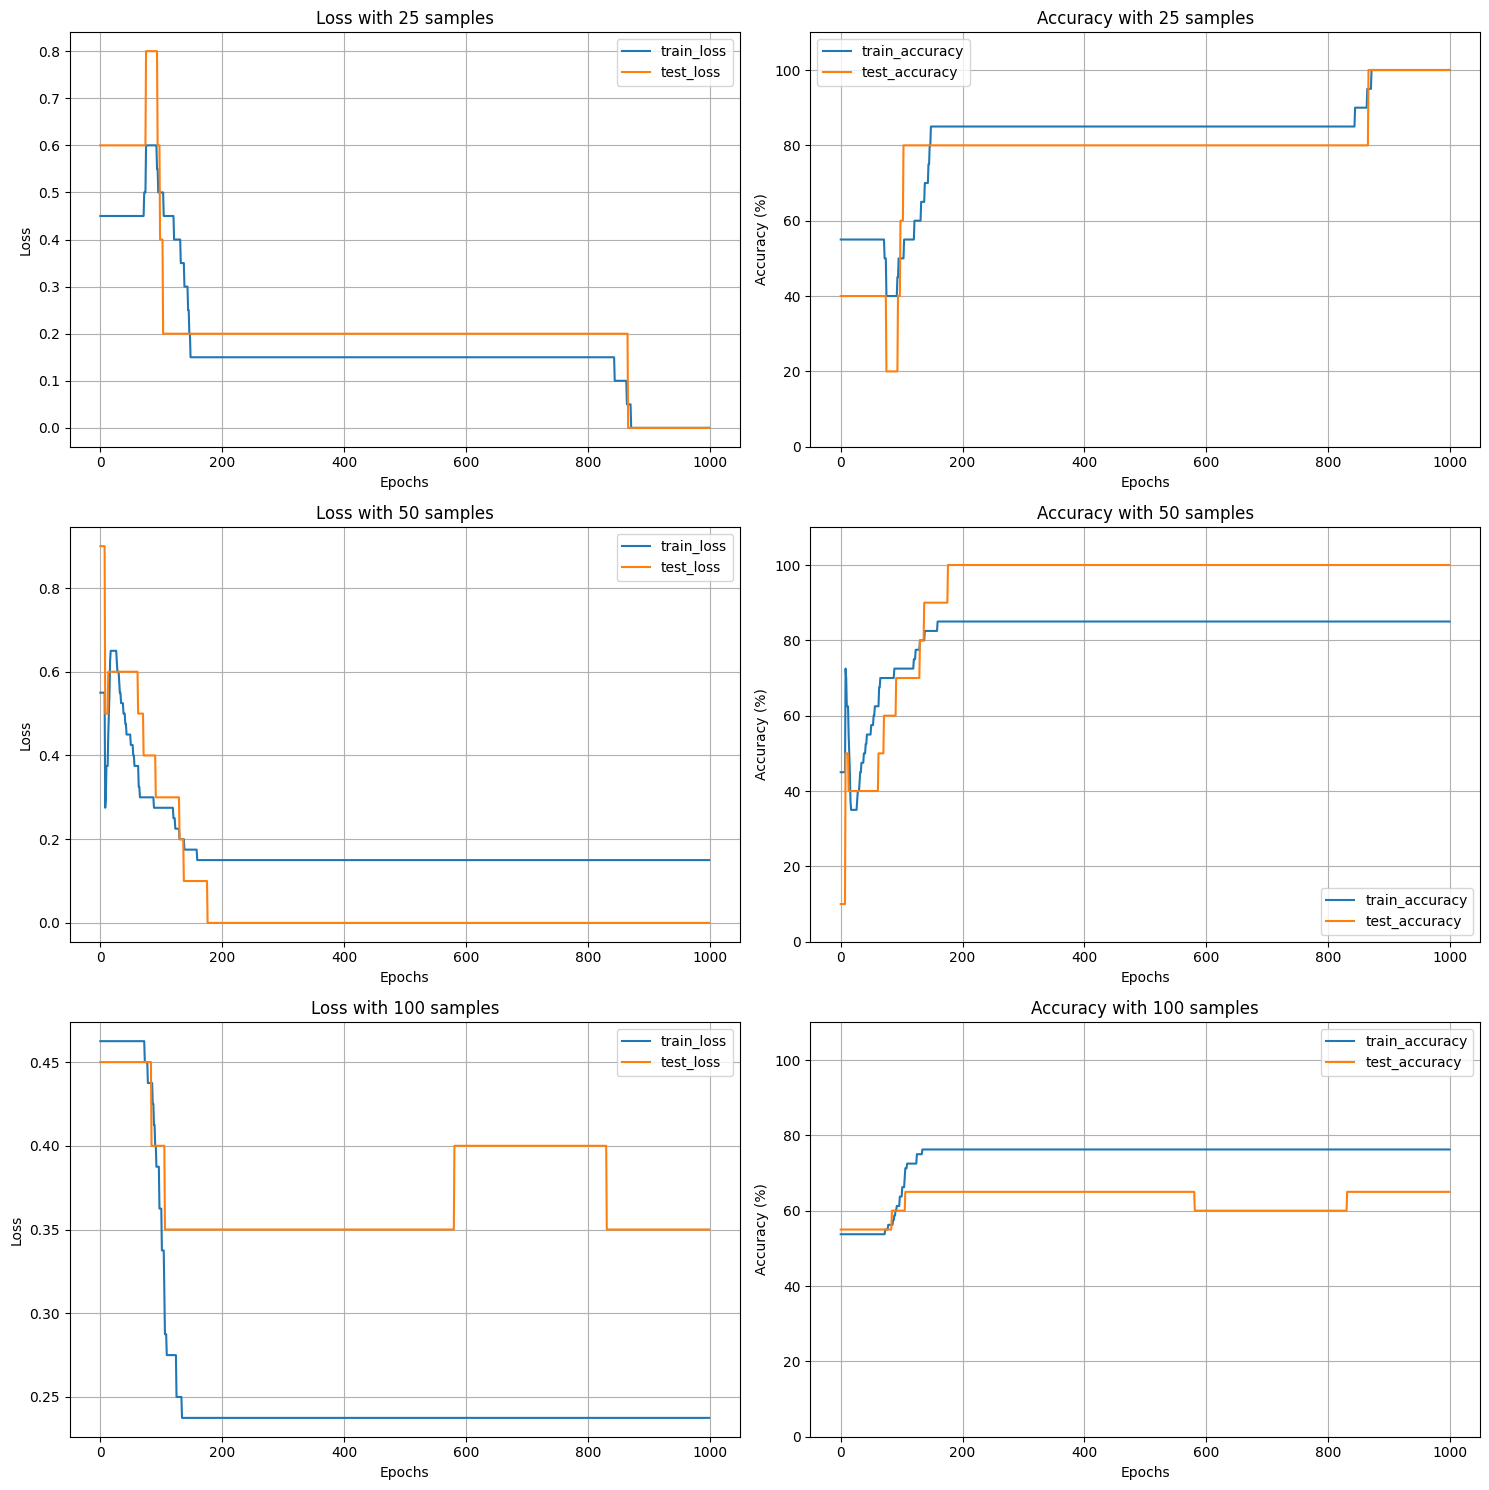

In [8]:
# Plot the results
fig, ax = plt.subplots(len(num_samples_values), 2, figsize=(15, 15))

for i, history in enumerate(histories):
    ax[i, 0].plot(history["train_loss"], label="train_loss")
    ax[i, 0].plot(history["test_loss"], label="test_loss")
    ax[i, 0].set_title(f"Loss with {num_samples_values[i]} samples")
    ax[i, 0].set_xlabel("Epochs")
    ax[i, 0].set_ylabel("Loss")
    ax[i, 0].legend()
    ax[i, 0].grid()

    ax[i, 1].plot(history["train_accuracy"], label="train_accuracy")
    ax[i, 1].plot(history["test_accuracy"], label="test_accuracy")
    ax[i, 1].set_title(f"Accuracy with {num_samples_values[i]} samples")
    ax[i, 1].set_xlabel("Epochs")
    ax[i, 1].set_ylabel("Accuracy (%)")
    ax[i, 1].legend()
    ax[i, 1].set_ylim([0, 110])
    ax[i, 1].grid()

plt.tight_layout()
plt.show()

Using Stochastic Gradient Descent

In [9]:
N = 40
X, Y = generate_dataset(N, op = 'xor', std_dev=0.1)
# Split the data into training and testing sets
split_index = int(SPLIT_RATIO * N)
X_train, X_test = X[:split_index], X[split_index:]
Y_train, Y_test = Y[:split_index], Y[split_index:]

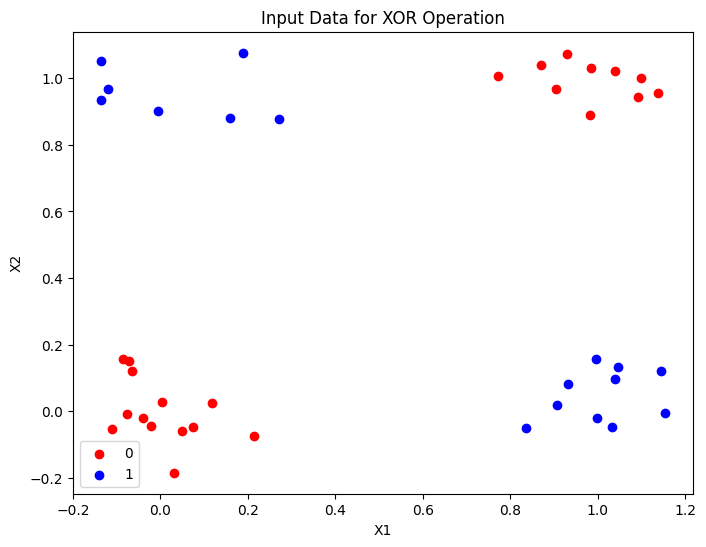

In [10]:
# Create a plot of the input data
scatter_plot_data(X, Y, title='Input Data for XOR Operation')

Note that XOR operation is not linearly separable.

In [11]:
batch_sizes = [4, 8, 16]
histories = []

for b in batch_sizes:

    model = ANN(INPUT_NODES, HIDDEN_NODES, OUTPUT_NODES)

    print(f"Training with batch size {b}:")

    history = model.train(X_train, Y_train,
                          X_test = X_test,
                          Y_test = Y_test,
                          batch_size = b,
                          epochs = NUM_EPOCHS,
                          lr = LR_XOR,
                          verbose=False)
    histories.append(history)
    print("")

Training with batch size 4:
 loss: 0.0000 - accuracy: 100.0000 - val_loss: 0.0000 - val_accuracy: 100.0000

Training with batch size 8:
 loss: 0.0000 - accuracy: 100.0000 - val_loss: 0.0000 - val_accuracy: 100.0000

Training with batch size 16:
 loss: 0.0000 - accuracy: 100.0000 - val_loss: 0.0000 - val_accuracy: 100.0000



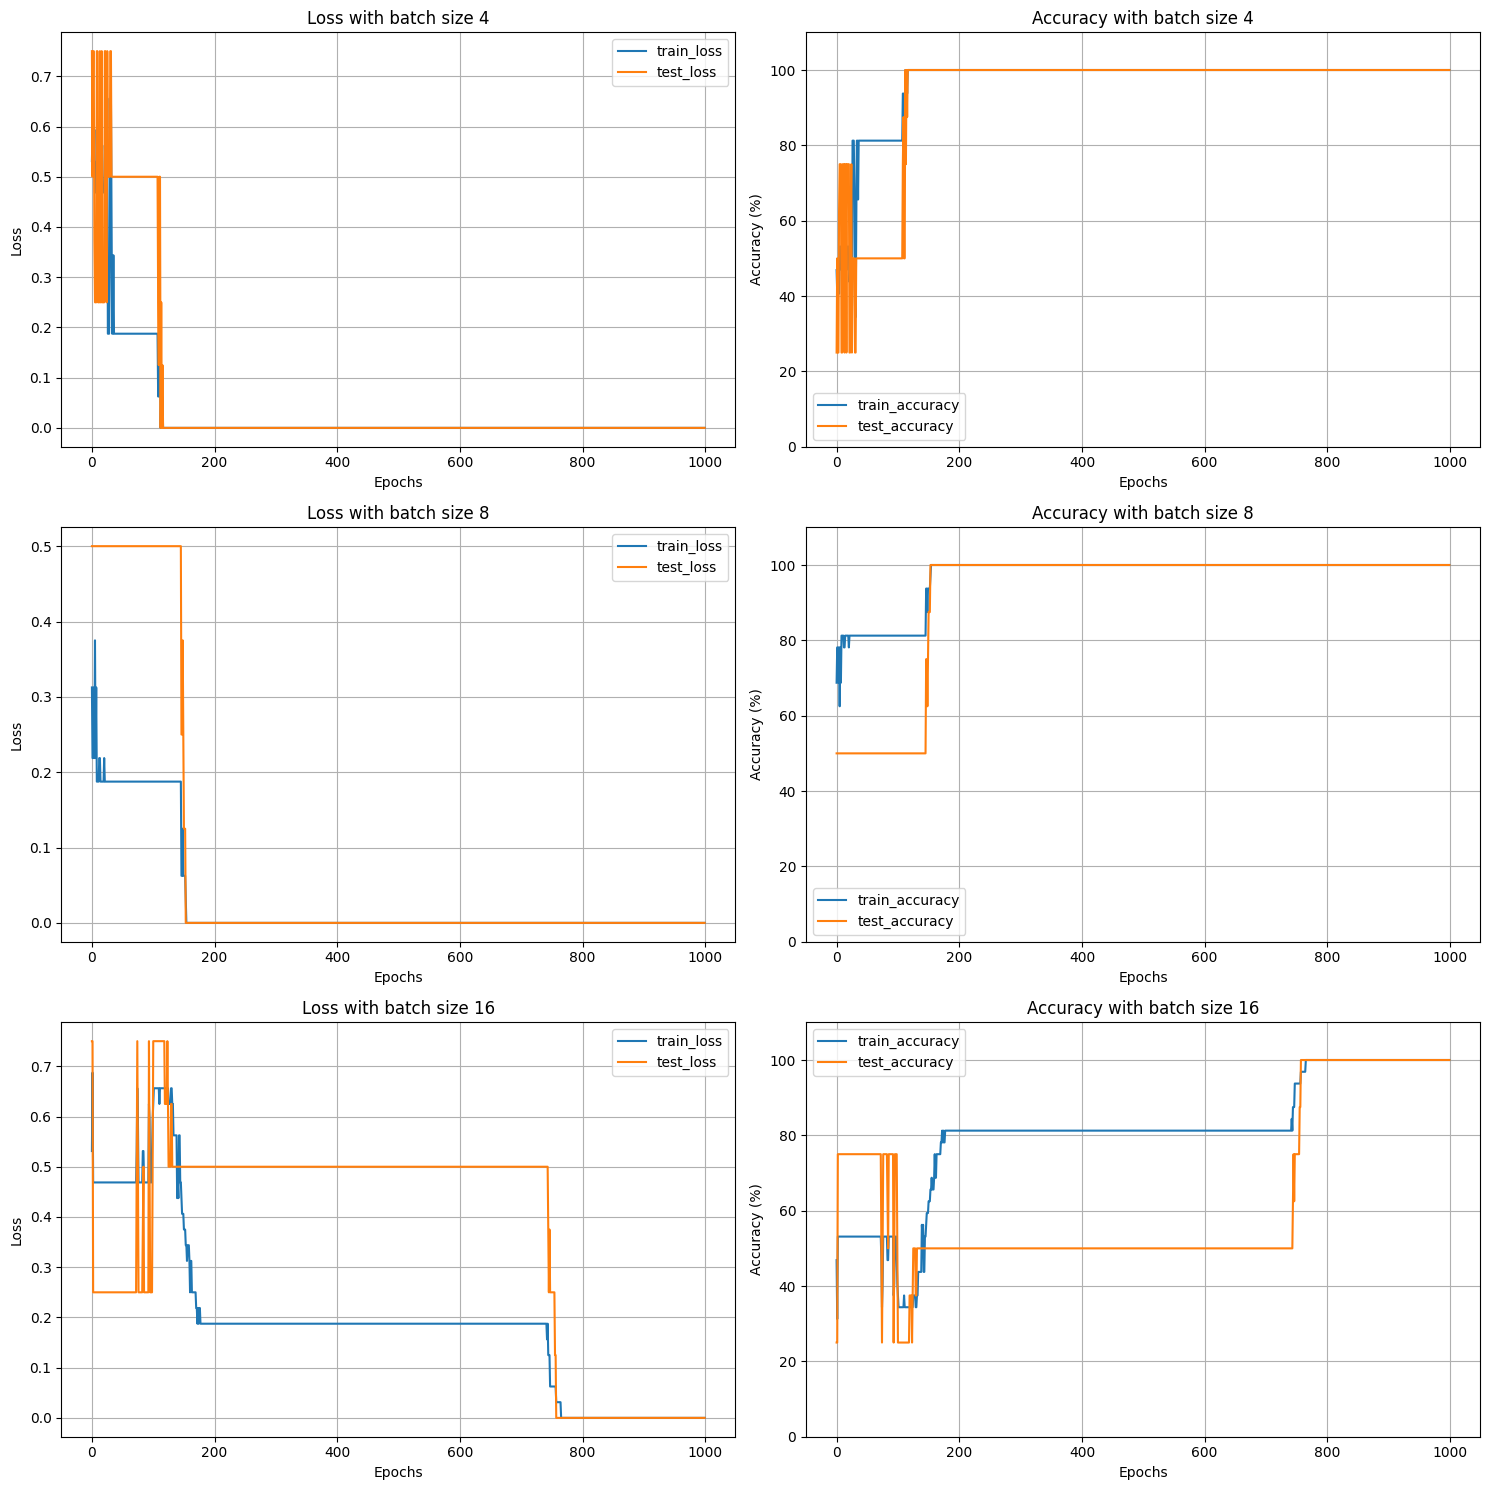

In [12]:
# Plot the results
fig, ax = plt.subplots(len(batch_sizes), 2, figsize=(15, 15))

for i, history in enumerate(histories):
    ax[i, 0].plot(history["train_loss"], label="train_loss")
    ax[i, 0].plot(history["test_loss"], label="test_loss")
    ax[i, 0].set_title(f"Loss with batch size {batch_sizes[i]}")
    ax[i, 0].set_xlabel("Epochs")
    ax[i, 0].set_ylabel("Loss")
    ax[i, 0].legend()
    ax[i, 0].grid()

    ax[i, 1].plot(history["train_accuracy"], label="train_accuracy")
    ax[i, 1].plot(history["test_accuracy"], label="test_accuracy")
    ax[i, 1].set_title(f"Accuracy with batch size {batch_sizes[i]}")
    ax[i, 1].set_xlabel("Epochs")
    ax[i, 1].set_ylabel("Accuracy (%)")
    ax[i, 1].legend()
    ax[i, 1].set_ylim([0, 110])
    ax[i, 1].grid()

plt.tight_layout()
plt.show()

### Learn AND operation

In [13]:
# Constants for the AND operation
NUM_EPOCHS = 600
SPLIT_RATIO = 0.8
LR_AND = 1.25

Train the ANN model on three different values of `num_samples` using Deterministic Gradient Descent

In [14]:
num_samples_values = [25, 50, 100]
histories = []

for n in num_samples_values:
    X, Y = generate_dataset(n, op = 'and')

    # Split the data into training and testing sets
    split_index = int(SPLIT_RATIO * n)
    X_train, X_test = X[:split_index], X[split_index:]
    Y_train, Y_test = Y[:split_index], Y[split_index:]

    num_train_samples = X_train.shape[0]

    model = ANN(INPUT_NODES, HIDDEN_NODES, OUTPUT_NODES)

    print(f"Training with {n} samples:")

    history = model.train(X_train, Y_train,
                          X_test = X_test,
                          Y_test = Y_test,
                          batch_size = num_train_samples,
                          epochs = NUM_EPOCHS,
                          lr = LR_AND,
                          verbose=False)
    histories.append(history)
    print("")

Training with 25 samples:
 loss: 0.0000 - accuracy: 100.0000 - val_loss: 0.0000 - val_accuracy: 100.0000

Training with 50 samples:
 loss: 0.0000 - accuracy: 100.0000 - val_loss: 0.0000 - val_accuracy: 100.0000

Training with 100 samples:
 loss: 0.0000 - accuracy: 100.0000 - val_loss: 0.0000 - val_accuracy: 100.0000



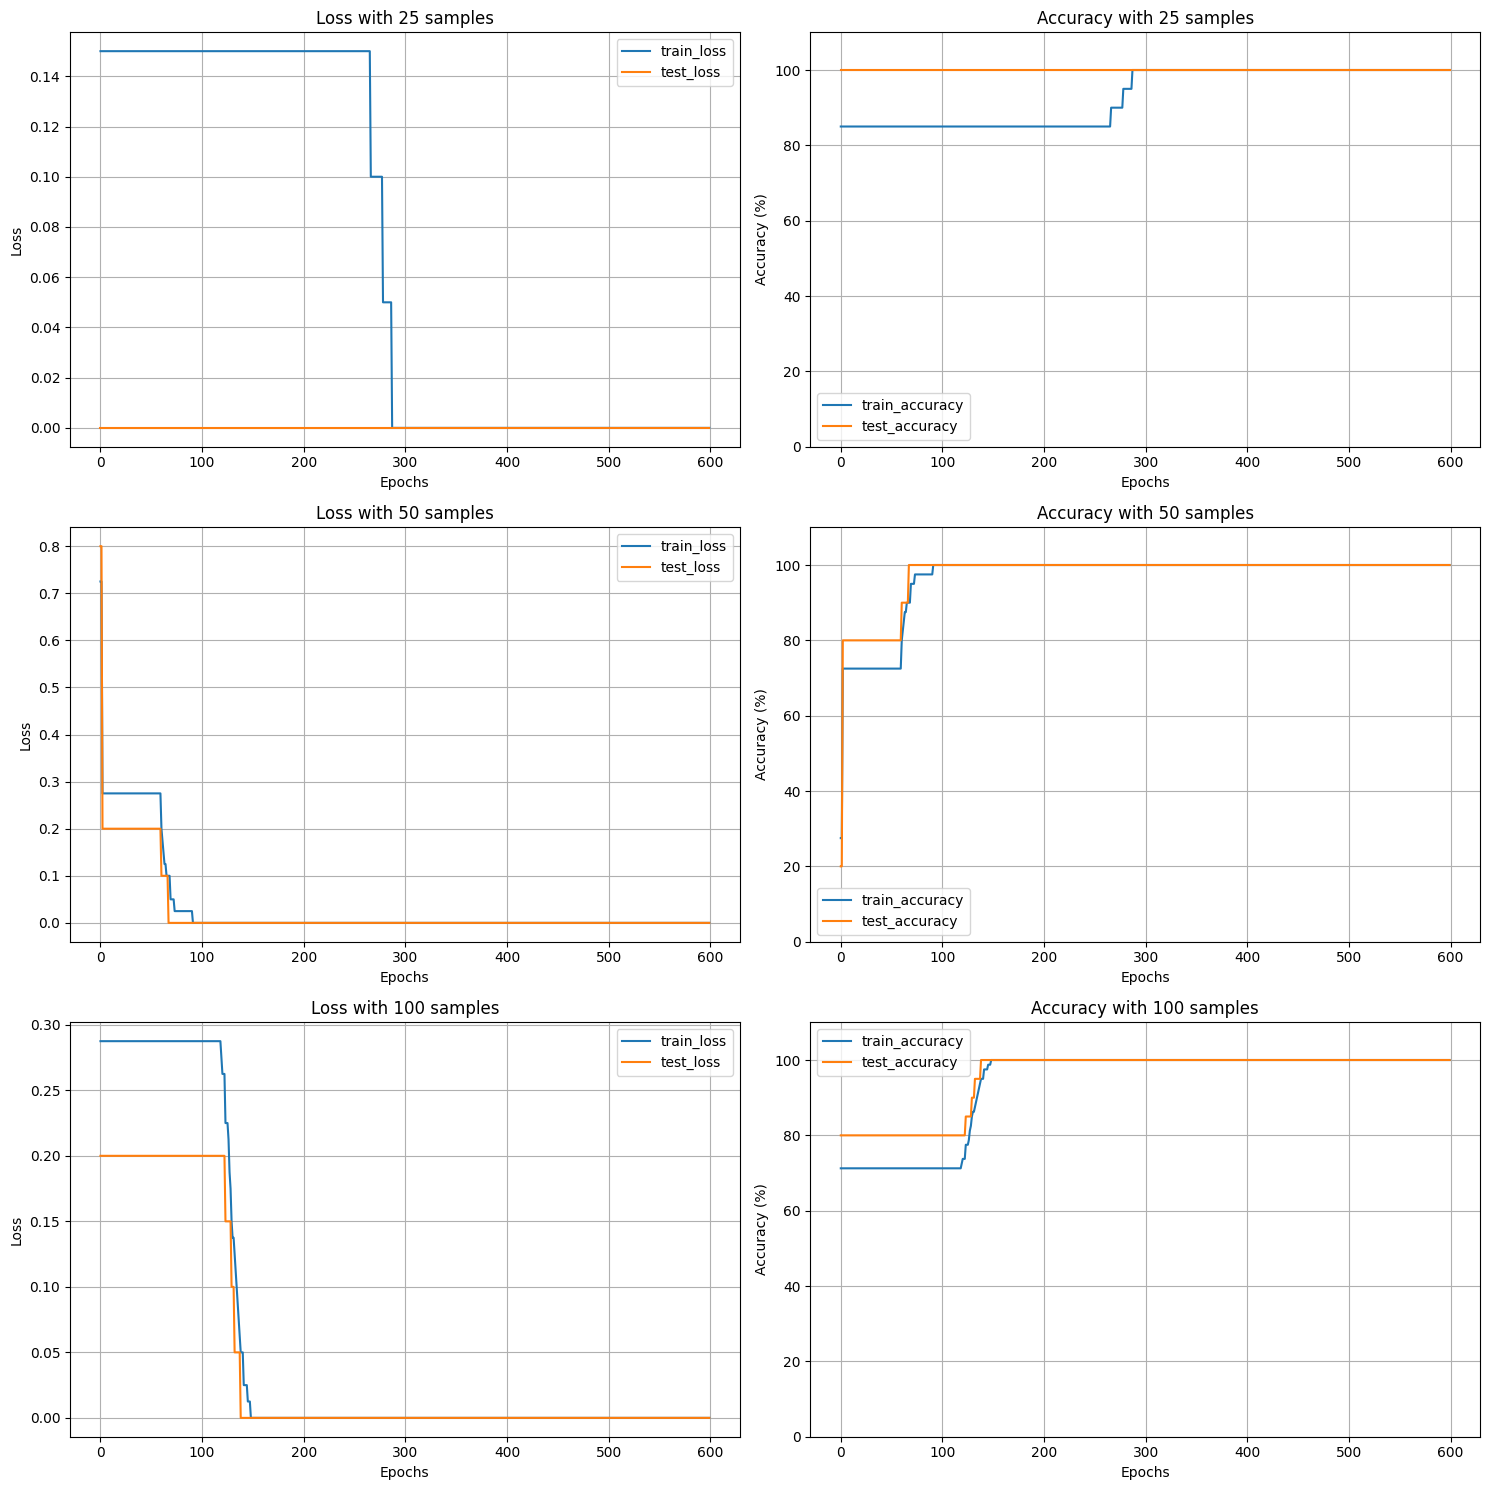

In [15]:
# Plot the results
fig, ax = plt.subplots(len(num_samples_values), 2, figsize=(15, 15))

for i, history in enumerate(histories):
    ax[i, 0].plot(history["train_loss"], label="train_loss")
    ax[i, 0].plot(history["test_loss"], label="test_loss")
    ax[i, 0].set_title(f"Loss with {num_samples_values[i]} samples")
    ax[i, 0].set_xlabel("Epochs")
    ax[i, 0].set_ylabel("Loss")
    ax[i, 0].legend()
    ax[i, 0].grid()

    ax[i, 1].plot(history["train_accuracy"], label="train_accuracy")
    ax[i, 1].plot(history["test_accuracy"], label="test_accuracy")
    ax[i, 1].set_title(f"Accuracy with {num_samples_values[i]} samples")
    ax[i, 1].set_xlabel("Epochs")
    ax[i, 1].set_ylabel("Accuracy (%)")
    ax[i, 1].legend()
    ax[i, 1].set_ylim([0, 110])
    ax[i, 1].grid()

plt.tight_layout()
plt.show()

Using Stochastic Gradient Descent

In [16]:
N = 100
X, Y = generate_dataset(N, op = 'and')
# Split the data into training and testing sets
split_index = int(SPLIT_RATIO * N)
X_train, X_test = X[:split_index], X[split_index:]
Y_train, Y_test = Y[:split_index], Y[split_index:]

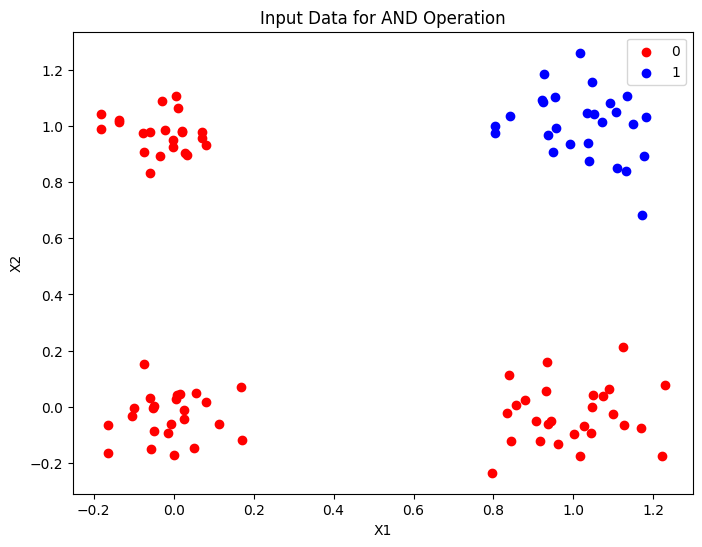

In [17]:
# Create a plot of the input data
scatter_plot_data(X, Y, title='Input Data for AND Operation')

Note that AND operation is linearly separable.

In [18]:
batch_sizes = [8, 16, 40]
histories = []

for b in batch_sizes:

    model = ANN(INPUT_NODES, HIDDEN_NODES, OUTPUT_NODES)

    print(f"Training with batch size {b}:")

    history = model.train(X_train, Y_train,
                          X_test = X_test,
                          Y_test = Y_test,
                          batch_size = b,
                          epochs = NUM_EPOCHS,
                          lr = LR_AND,
                          verbose=False)
    histories.append(history)
    print("")

Training with batch size 8:
 loss: 0.0000 - accuracy: 100.0000 - val_loss: 0.0000 - val_accuracy: 100.0000

Training with batch size 16:
 loss: 0.0000 - accuracy: 100.0000 - val_loss: 0.0000 - val_accuracy: 100.0000

Training with batch size 40:
 loss: 0.0000 - accuracy: 100.0000 - val_loss: 0.0000 - val_accuracy: 100.0000



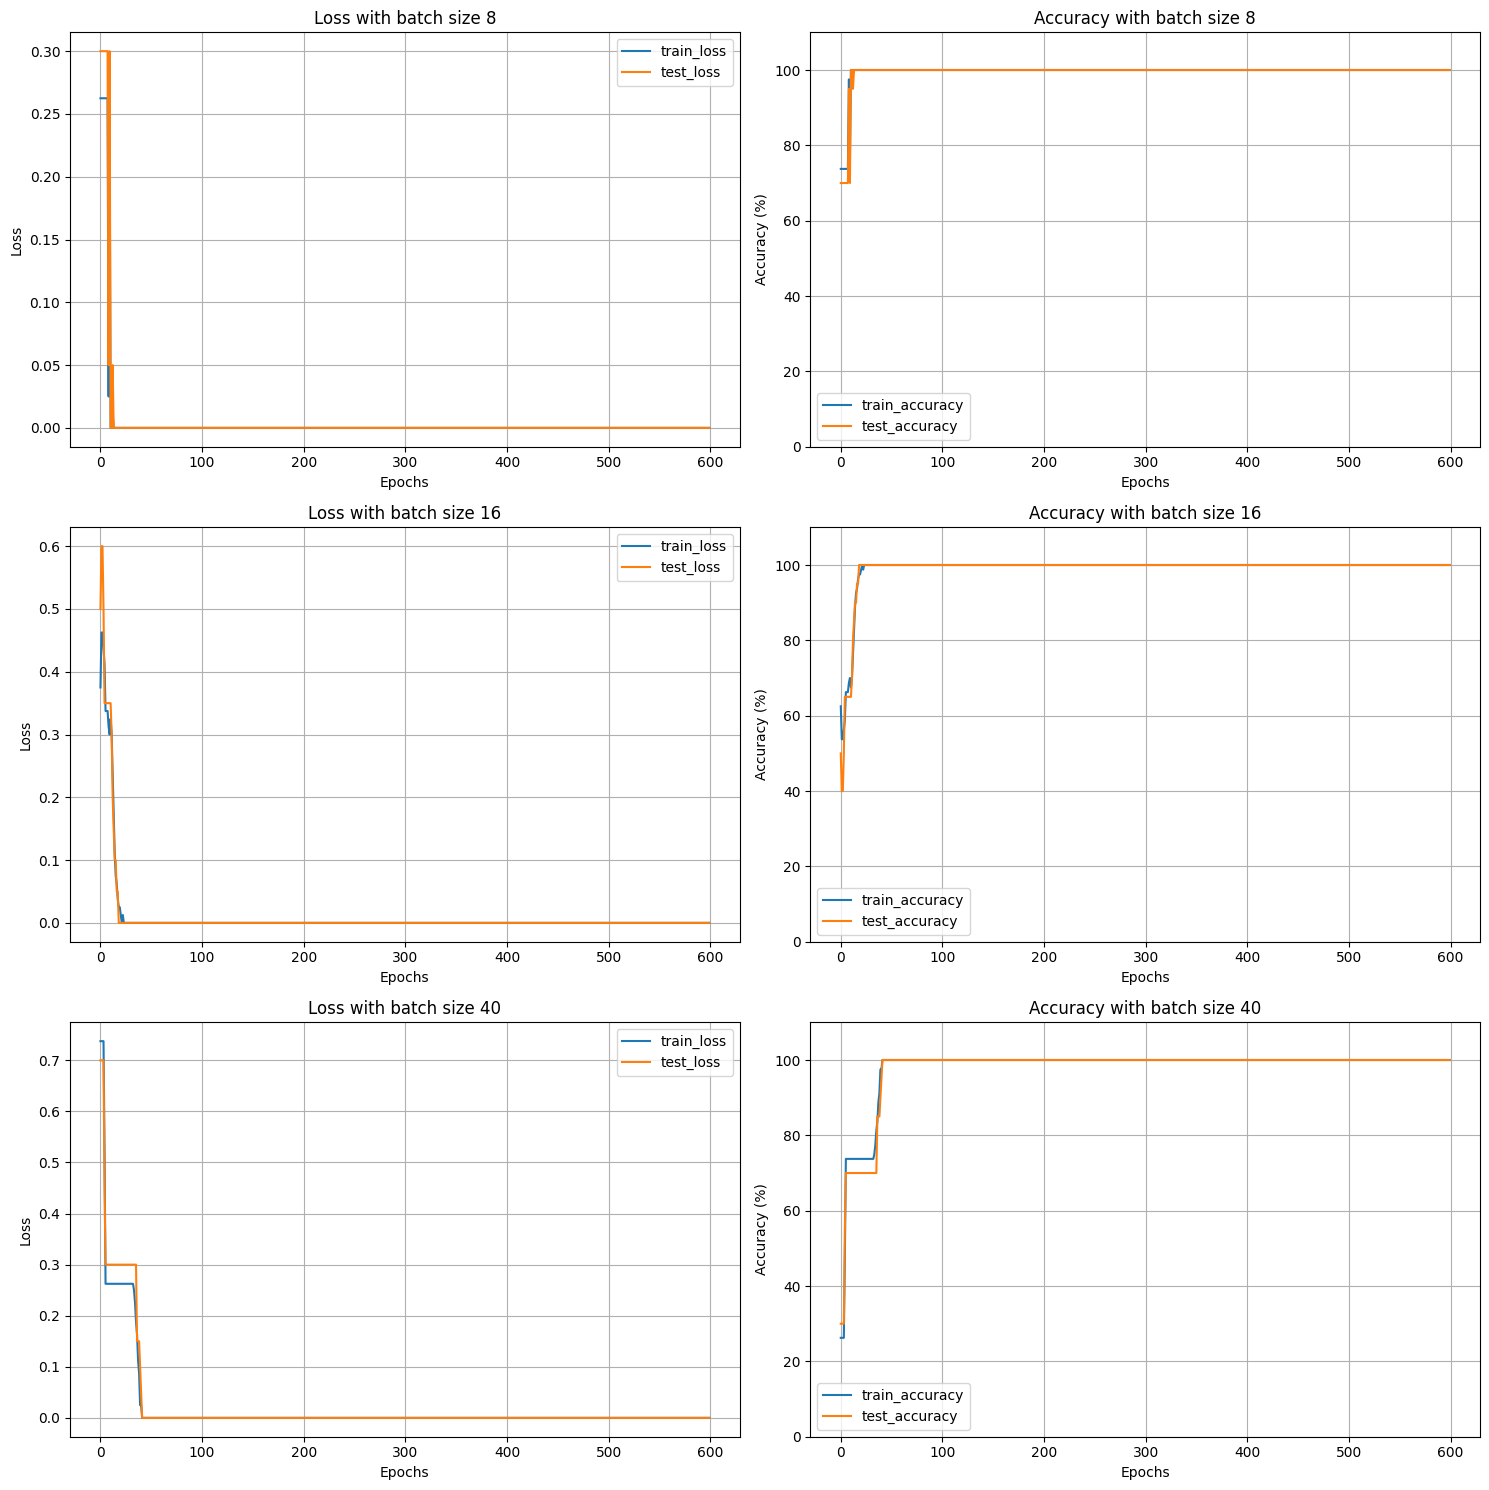

In [19]:
# Plot the results
fig, ax = plt.subplots(len(batch_sizes), 2, figsize=(15, 15))

for i, history in enumerate(histories):
    ax[i, 0].plot(history["train_loss"], label="train_loss")
    ax[i, 0].plot(history["test_loss"], label="test_loss")
    ax[i, 0].set_title(f"Loss with batch size {batch_sizes[i]}")
    ax[i, 0].set_xlabel("Epochs")
    ax[i, 0].set_ylabel("Loss")
    ax[i, 0].legend()
    ax[i, 0].grid()

    ax[i, 1].plot(history["train_accuracy"], label="train_accuracy")
    ax[i, 1].plot(history["test_accuracy"], label="test_accuracy")
    ax[i, 1].set_title(f"Accuracy with batch size {batch_sizes[i]}")
    ax[i, 1].set_xlabel("Epochs")
    ax[i, 1].set_ylabel("Accuracy (%)")
    ax[i, 1].legend()
    ax[i, 1].set_ylim([0, 110])
    ax[i, 1].grid()

plt.tight_layout()
plt.show()

### Learn OR operation

In [20]:
# Constants for the OR operation
NUM_EPOCHS = 600
SPLIT_RATIO = 0.8
LR_OR = 1.25

Train the ANN model on three different values of `num_samples` using Deterministic Gradient Descent

In [21]:
num_samples_values = [25, 50, 100]
histories = []

for n in num_samples_values:
    X, Y = generate_dataset(n, op = 'or')

    # Split the data into training and testing sets
    split_index = int(SPLIT_RATIO * n)
    X_train, X_test = X[:split_index], X[split_index:]
    Y_train, Y_test = Y[:split_index], Y[split_index:]

    num_train_samples = X_train.shape[0]

    model = ANN(INPUT_NODES, HIDDEN_NODES, OUTPUT_NODES)

    print(f"Training with {n} samples:")

    history = model.train(X_train, Y_train,
                          X_test = X_test,
                          Y_test = Y_test,
                          batch_size = num_train_samples,
                          epochs = NUM_EPOCHS,
                          lr = LR_OR,
                          verbose=False)
    histories.append(history)
    print("")

Training with 25 samples:
 loss: 0.0000 - accuracy: 100.0000 - val_loss: 0.0000 - val_accuracy: 100.0000

Training with 50 samples:
 loss: 0.0000 - accuracy: 100.0000 - val_loss: 0.0000 - val_accuracy: 100.0000

Training with 100 samples:
 loss: 0.0000 - accuracy: 100.0000 - val_loss: 0.0000 - val_accuracy: 100.0000



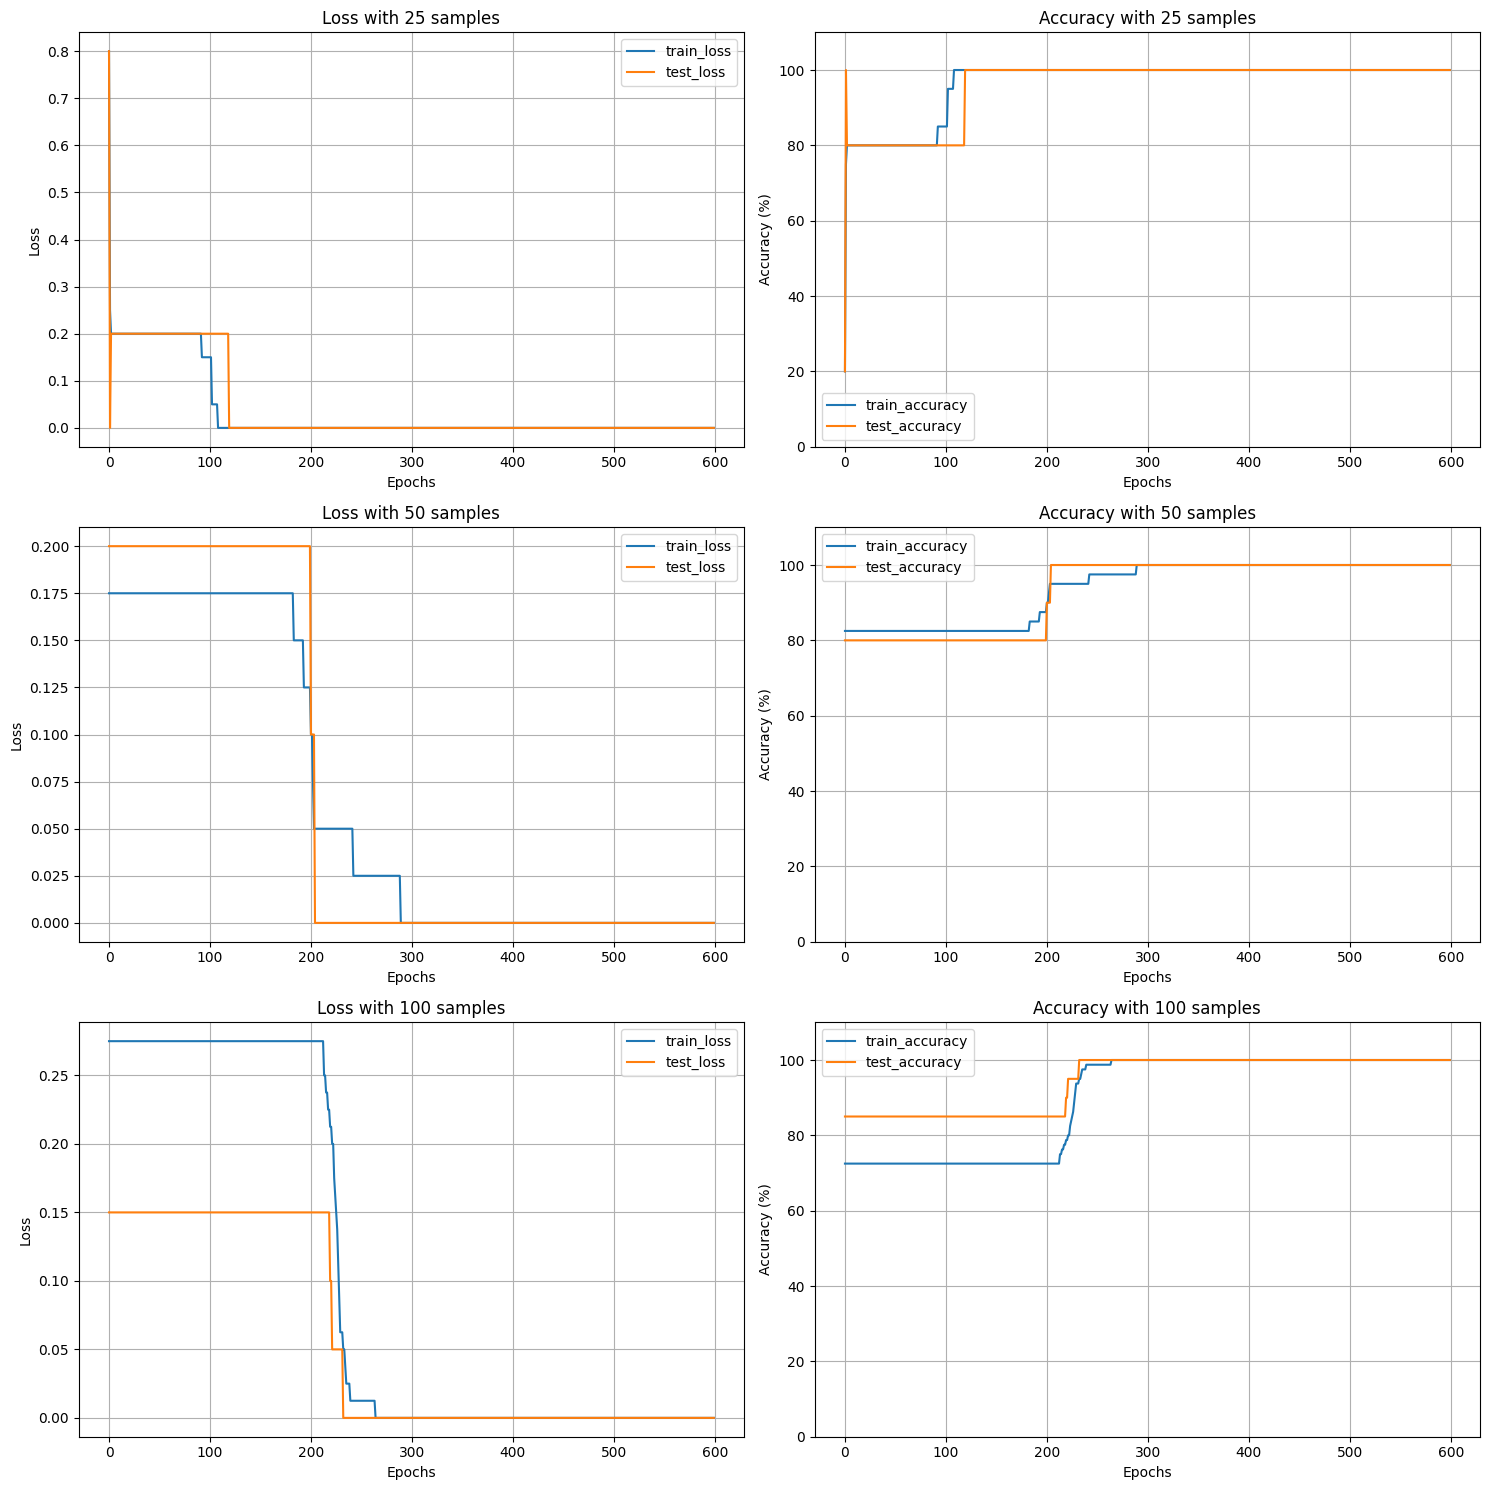

In [22]:
# Plot the results
fig, ax = plt.subplots(len(num_samples_values), 2, figsize=(15, 15))

for i, history in enumerate(histories):
    ax[i, 0].plot(history["train_loss"], label="train_loss")
    ax[i, 0].plot(history["test_loss"], label="test_loss")
    ax[i, 0].set_title(f"Loss with {num_samples_values[i]} samples")
    ax[i, 0].set_xlabel("Epochs")
    ax[i, 0].set_ylabel("Loss")
    ax[i, 0].legend()
    ax[i, 0].grid()

    ax[i, 1].plot(history["train_accuracy"], label="train_accuracy")
    ax[i, 1].plot(history["test_accuracy"], label="test_accuracy")
    ax[i, 1].set_title(f"Accuracy with {num_samples_values[i]} samples")
    ax[i, 1].set_xlabel("Epochs")
    ax[i, 1].set_ylabel("Accuracy (%)")
    ax[i, 1].legend()
    ax[i, 1].set_ylim([0, 110])
    ax[i, 1].grid()

plt.tight_layout()
plt.show()

Using Stochastic Gradient Descent

In [23]:
N = 100
X, Y = generate_dataset(N, op = 'or')
# Split the data into training and testing sets
split_index = int(SPLIT_RATIO * N)
X_train, X_test = X[:split_index], X[split_index:]
Y_train, Y_test = Y[:split_index], Y[split_index:]

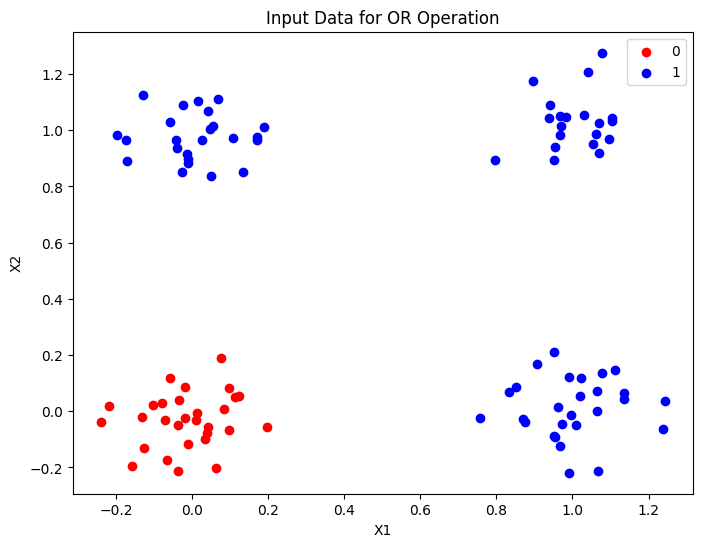

In [24]:
# Create a plot of the input data
scatter_plot_data(X, Y, title='Input Data for OR Operation')

Note that OR operation is linearly separable.

In [25]:
batch_sizes = [8, 16, 40]
histories = []

for b in batch_sizes:

    model = ANN(INPUT_NODES, HIDDEN_NODES, OUTPUT_NODES)

    print(f"Training with batch size {b}:")

    history = model.train(X_train, Y_train,
                          X_test = X_test,
                          Y_test = Y_test,
                          batch_size = b,
                          epochs = NUM_EPOCHS,
                          lr = LR_OR,
                          verbose=False)
    histories.append(history)
    print("")

Training with batch size 8:
 loss: 0.0000 - accuracy: 100.0000 - val_loss: 0.0000 - val_accuracy: 100.0000

Training with batch size 16:
 loss: 0.0000 - accuracy: 100.0000 - val_loss: 0.0000 - val_accuracy: 100.0000

Training with batch size 40:
 loss: 0.0000 - accuracy: 100.0000 - val_loss: 0.0000 - val_accuracy: 100.0000



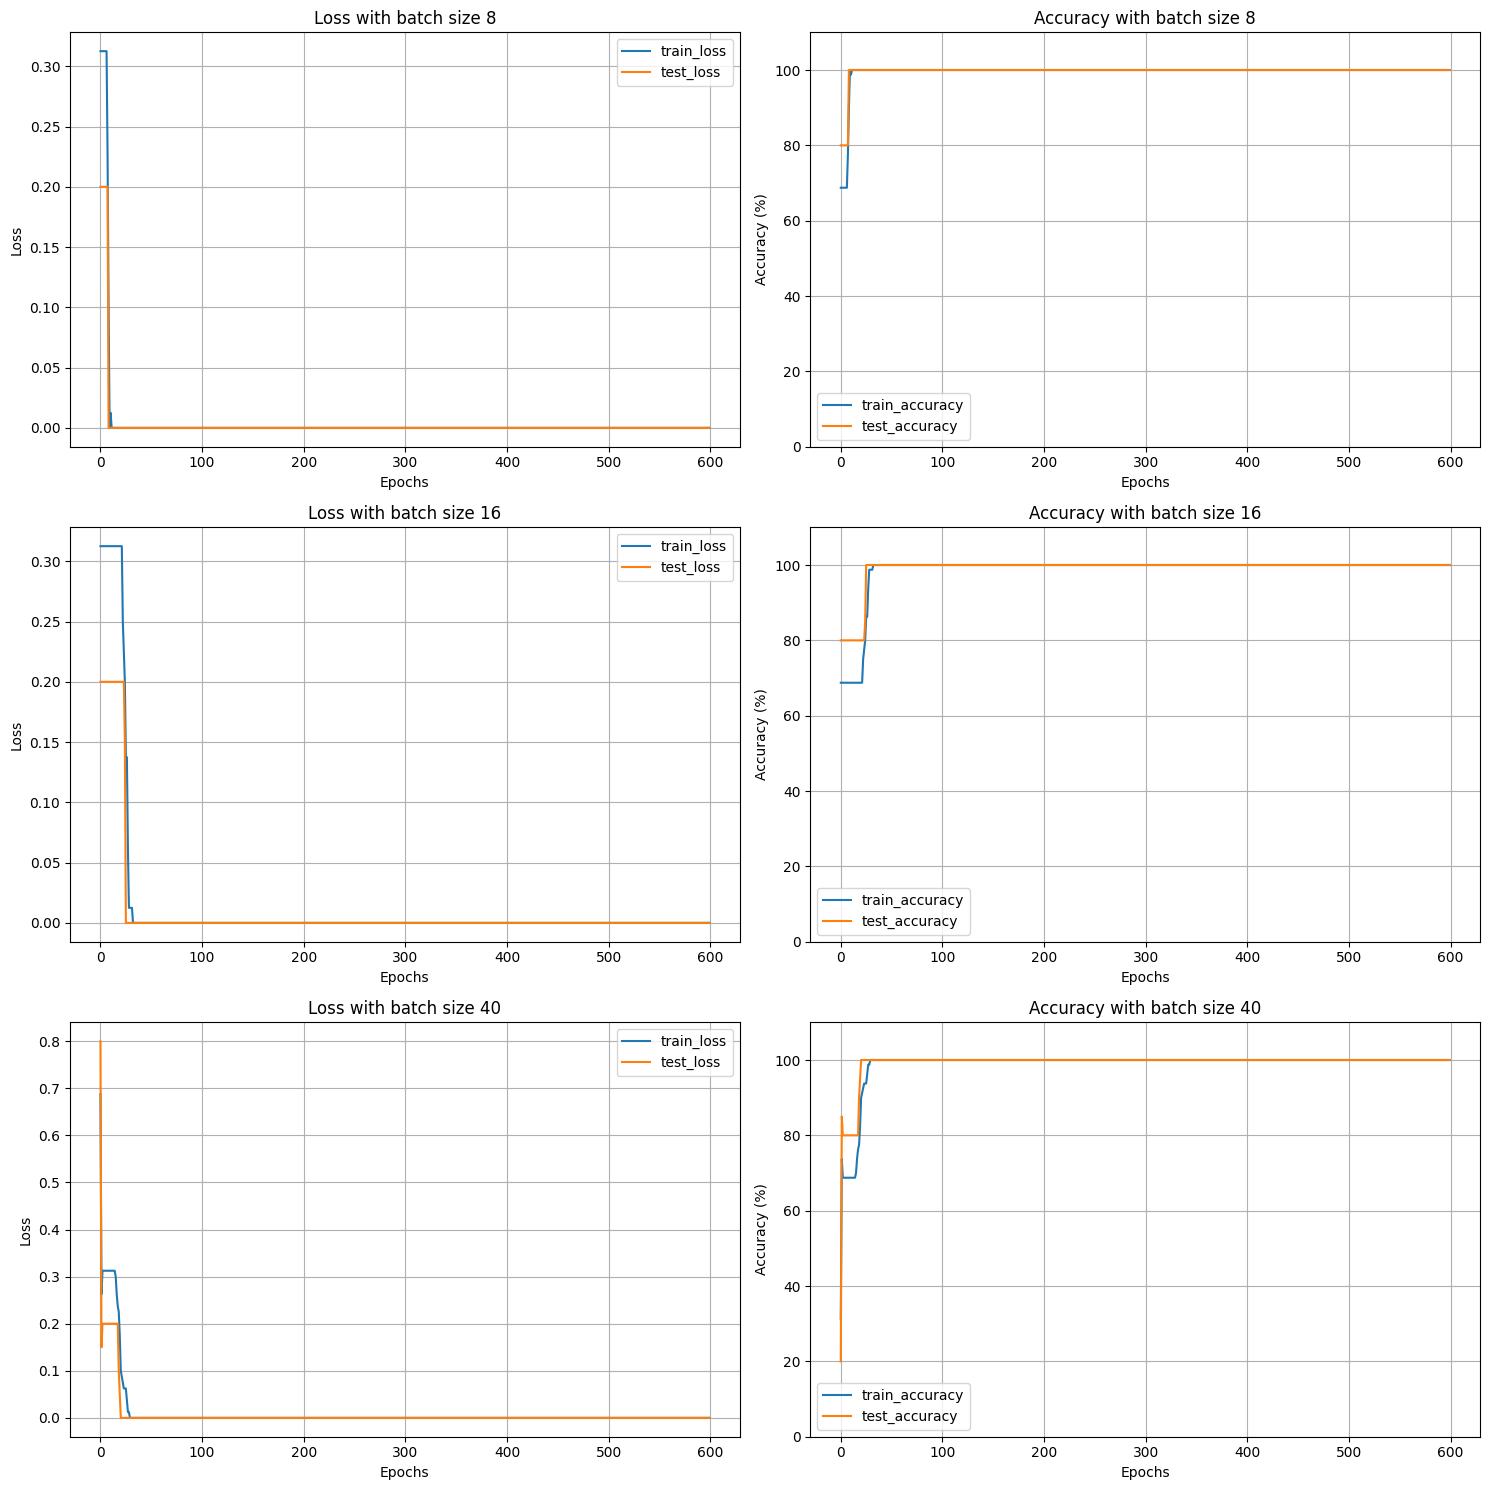

In [26]:
# Plot the results
fig, ax = plt.subplots(len(batch_sizes), 2, figsize=(15, 15))

for i, history in enumerate(histories):
    ax[i, 0].plot(history["train_loss"], label="train_loss")
    ax[i, 0].plot(history["test_loss"], label="test_loss")
    ax[i, 0].set_title(f"Loss with batch size {batch_sizes[i]}")
    ax[i, 0].set_xlabel("Epochs")
    ax[i, 0].set_ylabel("Loss")
    ax[i, 0].legend()
    ax[i, 0].grid()

    ax[i, 1].plot(history["train_accuracy"], label="train_accuracy")
    ax[i, 1].plot(history["test_accuracy"], label="test_accuracy")
    ax[i, 1].set_title(f"Accuracy with batch size {batch_sizes[i]}")
    ax[i, 1].set_xlabel("Epochs")
    ax[i, 1].set_ylabel("Accuracy (%)")
    ax[i, 1].legend()
    ax[i, 1].set_ylim([0, 110])
    ax[i, 1].grid()

plt.tight_layout()
plt.show()

**Q4: Effect of `num_samples` on the model performance**<br>
**Observation:** The model is not able to learn XOR operation when the number of samples are increased. This is because the model is too simple to generalize on a large number of samples.
However, since AND and OR operations are relatively simpler (linearly separable), the model is able to learn them even with a large number of samples.<br><br>

**Q5: Effect of `batch_size` on the model performance**<br>
**Observation:** For small batch size, the penalty for estimating the true loss using a small batch is quite high at the beginning. Therefore, sometimes the value of loss fluctuates a lot initially, which is not an issue with higher batch size.<br>
This behaviour is clearly visible in case of XOR operation which is more difficult to learn as compared to AND and OR operations.